#### Lecture 7 - Matrix inverse, iterative methods

Matrix from C&C Case Study 12.1 - system of 5 reactors with unknown concentrations.

- Find matrix inverse using LU, compare to scipy.linalg.inv
- Interpret inverse coefficients as system response to forcing
- Check the condition number
- Check if diagonally dominant
- Implement Gauss-Seidel and plot convergence 

In [1]:
import numpy as np
import scipy.linalg as sl

A = np.array([[6, 0, -1, 0, 0],
              [-3, 3, 0, 0, 0],
              [0, -1, 9, 0, 0],
              [0, -1, -8, 11, -2],
              [-3, -1, 0, 0, 4]])

b = np.array([50, 0, 160, 0, 0]).T

n = A.shape[0]

In [2]:
# the values are entered as ints, change to floats
print(A.dtype)
A = A.astype(float)
b = b.astype(float)
print(A.dtype)

int64
float64


In [3]:
# LU decomposition
# this does not include partial pivoting and may encounter divide by zero errors
# see C&C Figure 10.2 for pseudocode for LU with partial pivoting
U = A.copy()
L = np.eye(n)

for k in range(n-1):
    for i in range(k+1,n): 
        L[i,k] = U[i,k] / U[k,k] # multiplying factor
        U[i,:] = U[i,:] - L[i,k] * U[k,:] # modify row i based on pivot row k

##### Solve for matrix inverse using LU decomposition

First we will write the forward/back substitution routine as a function, since we will call it many times while calculating the inverse.

In [4]:
# given L, U, b return x such that LUx = b
def forward_back_sub(L, U, b):
    d = np.zeros(n)
    d[0] = b[0] / L[0,0]

    for i in range(1,n):
        d[i] = (b[i] - L[i,:] @ d) / L[i,i]

    # back substitution
    x = np.zeros(n)
    x[-1] = d[-1] / U[-1,-1] # index -1 for last element

    for i in range(n-2,-1,-1): # loop backward starting from second-to-last row
        x[i] = (d[i] - U[i,i+1:n] @ x[i+1:n]) / U[i,i]  

    return x

Use this function to solve for each column of the inverse, setting the right-hand side to the column from the identity matrix. Note the original $\mathbf{b}$ vector is not used here. The inverse only depends on $\mathbf{A}$.

In [5]:
# solve for inverse using RHS columns from I
I = np.eye(n)
Ainv = np.zeros((n,n))
for j in range(n):
    Ainv[:,j] = forward_back_sub(L, U, I[:,j])

np.set_printoptions(precision=3, suppress=True)
print(Ainv)
print('Matches Scipy? ', np.allclose(Ainv, sl.inv(A)))

[[0.17  0.006 0.019 0.    0.   ]
 [0.17  0.34  0.019 0.    0.   ]
 [0.019 0.038 0.113 0.    0.   ]
 [0.06  0.075 0.087 0.091 0.045]
 [0.17  0.09  0.019 0.    0.25 ]]
Matches Scipy?  True


##### Interpreting inverse
The coefficients from the inverse help us interpret the relationship between the forcing and the unknown system states. Last time we changed the input forcing $c_{01}=10$ to $c_{01}=20$ and solved again to find the unknown states. Here we can see that inverse coefficients $a_{ij}^{-1}$ represent the change in state variable $i$ per unit change in forcing $j$. 

Because input $c_{01}$ shows up in the first forcing element $b_1$, we would expect (for example) the unknown $c_2$ to change by $0.17 (20-10) = 1.7$ units. The change in $c_3$ would be $0.019 (20-10) = 0.19$ units.

This interpretation depends on the order of the equations in the original matrix, which is arbitrary depending how the state variables are numbered.



##### Condition number

In [6]:
np.linalg.cond(A, 'fro') # use the Frobenius (Euclidean) norm

10.548943021482339

In [7]:
sl.norm(A) * sl.norm(Ainv) # should match

10.548943021482339

The condition number is low. We are not concerned about a singular matrix. For an example of an ill-conditioned matrix, see below. The closer the value `1.00001` gets to 1, the higher the condition number will be, and the fewer digits of precision we will be able to trust in the result.

In [8]:
M = np.array([[10, 1], [10, 1.00001]])
np.linalg.cond(M, 'fro')

2020000.1999877666

##### Is the matrix diagonally dominant?
For every row, the magnitude of the main diagonal is greater than the sum of the magnitudes of all the other entries in that row. This will tell us if the Gauss-Seidel method will converge.

In [9]:
def is_diagonally_dominant(A):
    diag = np.diag(np.abs(A))
    rowsum = np.sum(np.abs(A), axis=1)
    return np.all(diag > rowsum - diag)

is_diagonally_dominant(A)

False

Unfortunately, in this problem our matrix is not going to work with the Gauss-Seidel method. Let's use the other matrix from the book instead to illustrate the point.

In [10]:
A = np.array([[8, 3, -3], [-2, -8, 5], [3, 5, 10]])
b = np.array([14, 5, -8]).T
is_diagonally_dominant(A)

True

##### Gauss-Seidel Iteration
The error is defined by the norm of $\mathbf{A}\mathbf{x} - \mathbf{b}$. Loop until tolerance `1e-8`.

In [11]:
n = 3
x = np.zeros(n)
err = 9999
errors = []
num_iter = 0

while err > 1e-8:
    for i in range(n): # loop over variables
        x[i]  = (b[i] - A[i,:] @ x + A[i,i] * x[i]) / A[i,i]
        # the summation is the full dot product minus the ith term
        # so it gets added back in here

    err = sl.norm(A @ x - b, 2) # Euclidean vector norm
    errors.append(err) # store these for plotting
    num_iter += 1

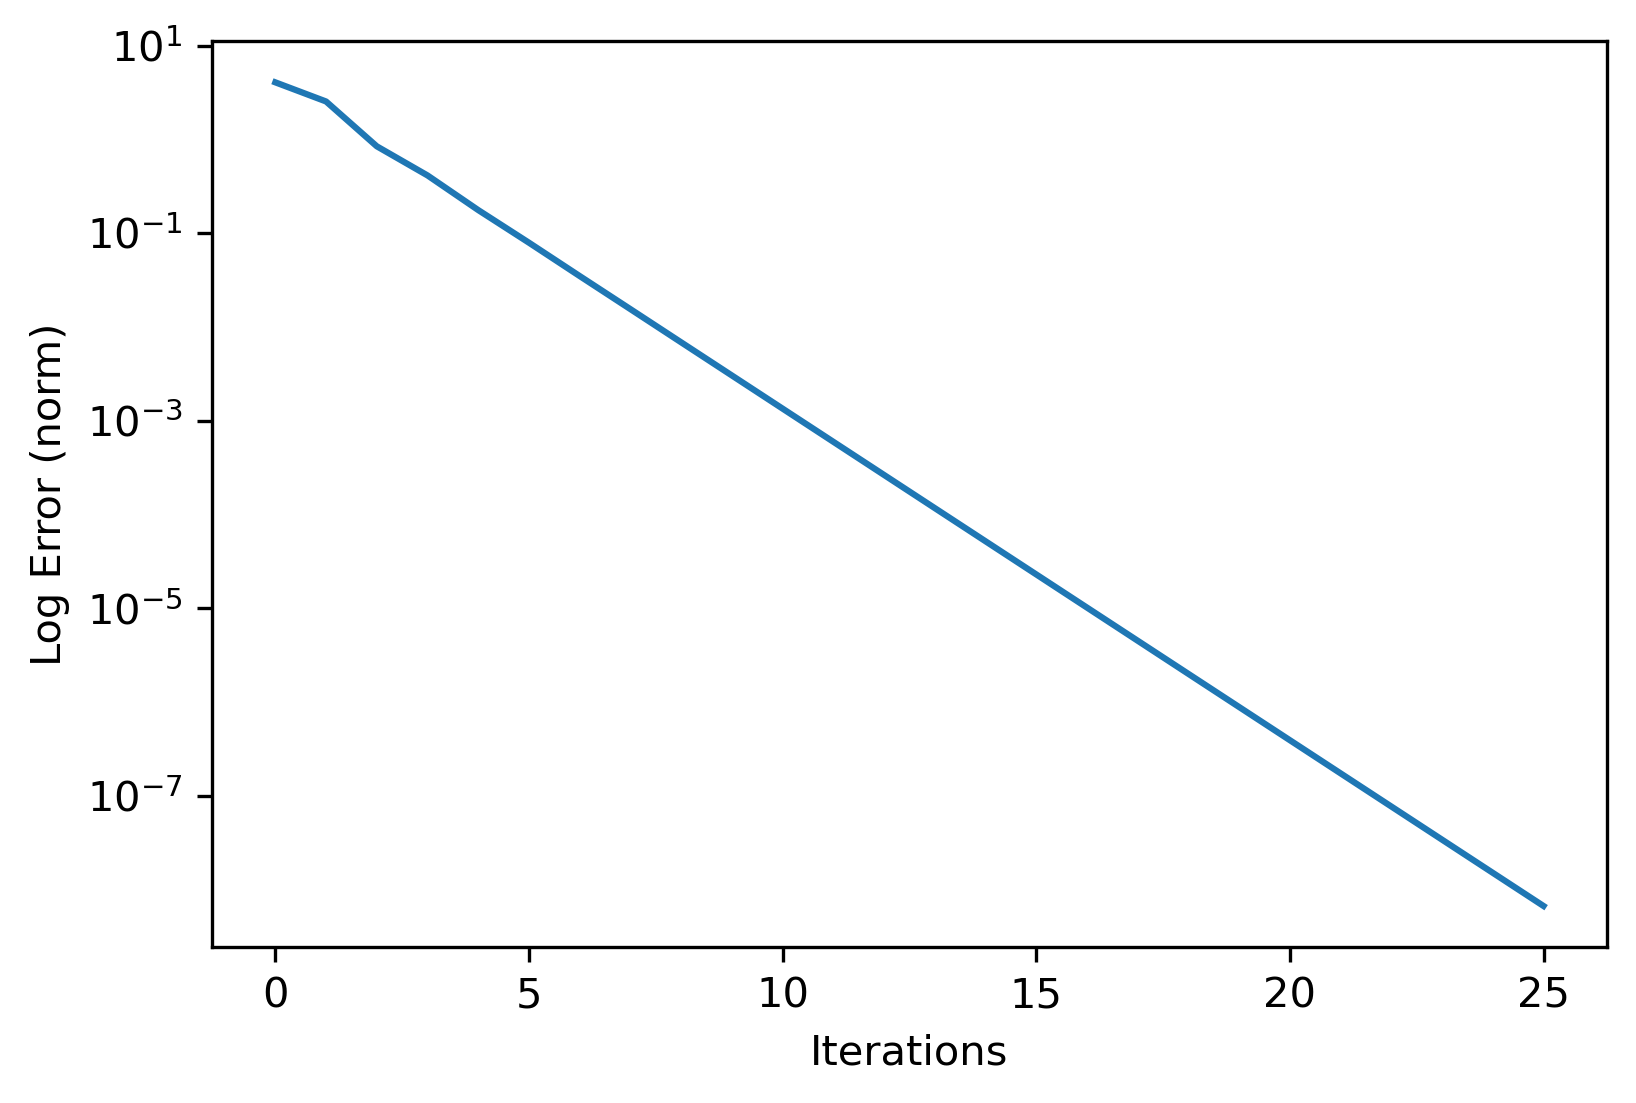

In [12]:
# plot convergence
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

plt.semilogy(errors)
plt.xlabel('Iterations')
plt.ylabel('Log Error (norm)')
plt.show()

Each iteration, $n$ variables are updated with a total of $n$ arithmetic operations each. If $k$ iterations are performed, the total operation count scales as $O(kn^2)$. Compared to Gauss elimination $O(n^3)$, this iterative method may be helpful in larger systems of equations where $k < n$. However, that is not the case here, where $n=3$ and $k=19$ iterations are needed to reach a tolerance of `1e-6`. 